<a href="https://colab.research.google.com/github/xiexukang/tensorflow-/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline


In [0]:
# kaggle mnist
def load_data(path):
    data = pd.read_csv(path)
    data_x = data.drop(['label'], axis=1).values
    data_y = data.label.values
    train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=1000)
    train_x = tf.cast(train_x, tf.float32)/255.0
    valid_x = tf.cast(valid_x, tf.float32)/255.0
    train_y = tf.cast(train_y, tf.int64)
    valid_y = tf.cast(valid_y, tf.int64)
    #train_x, valid_x = train_x/np.float64(255), valid_x/np.float64(255)
    train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
    # 采样
    train_ds = train_ds.take(10000).shuffle(10000).batch(500)
    valid_ds = valid_ds.batch(500)
    return train_ds , valid_ds


In [0]:
mnist = keras.datasets.mnist

In [0]:
(x_train, y_train), (x_test ,y_test) = mnist.load_data()

In [204]:
x_train.shape

(60000, 28, 28)

In [0]:
x_train = tf.cast(x_train, tf.float32)/255.0
x_test = tf.cast(x_test, tf.float32)/255.0
y_train = tf.cast(y_train, tf.int64)
y_test = tf.cast(y_test, tf.int64)


In [206]:
x_train.shape
y_train.shape

TensorShape([60000])

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [208]:
print(train_ds,valid_ds)

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float32, tf.int64)> <TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float32, tf.int64)>


In [0]:
train_ds = train_ds.take(10000).shuffle(10000).batch(500)
valid_ds = valid_ds.batch(500)

In [210]:
print(train_ds,valid_ds)

<BatchDataset shapes: ((None, 28, 28), (None,)), types: (tf.float32, tf.int64)> <BatchDataset shapes: ((None, 28, 28), (None,)), types: (tf.float32, tf.int64)>


In [211]:
y_train

<tf.Tensor: shape=(60000,), dtype=int64, numpy=array([5, 0, 4, ..., 5, 6, 8])>

In [0]:
# softmax cross entropy
def loss_function(labels, pred_proba):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=pred_proba)
    return tf.reduce_mean(loss)

def compute_accuracy(labels, pred_proba):
    predictions = tf.argmax(pred_proba, axis=1)
    return accuracy_score(labels, predictions)


In [0]:
def test(model, valid_ds):
    loss_ , accu_ = [], []
    for (images, labels) in valid_ds:
        pred_proba = model.predict_proba(images)
        loss_.append(loss_function(labels, pred_proba))
        accu_.append(compute_accuracy(labels, pred_proba))
    return np.mean(loss_), np.mean(accu_)


In [0]:
def train(model, epochs):
    compute_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    optimizer = optimizers.Adam(learning_rate=0.01)
    trainloss_list = []    # every step loss
    trainaccuracy_list = []
    
    for i in range(epochs):
        for step,(x, y) in enumerate(train_ds):
            with tf.GradientTape() as gdt:
                
                pred_proba = model(x, training=True)
                predictions = tf.argmax(pred_proba, axis=1)
                tloss_ = loss_function(y, pred_proba)
                taccu_ = accuracy_score(y, predictions)
                trainloss_list.append(tloss_)
                trainaccuracy_list.append(taccu_)
            # compute gradient
            grads = gdt.gradient(tloss_, model.trainable_variables)
            # update weights
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            if step%1000==0:
                print('Train loss is : %f, Train accuracy is : %f'%(tloss_, taccu_))
                
    return trainloss_list,trainaccuracy_list, model


In [215]:
for x,y in train_ds:
  print(x)
  print("*"*20)
  print(y)
  break

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

In [0]:
model = tf.keras.Sequential([layers.Reshape(target_shape=(28, 28, 1), input_shape=(28,28,)),
                             layers.BatchNormalization(),
                             layers.Conv2D(2, 3, padding='same', activation=tf.nn.relu),
                             layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
                             layers.Conv2D(4, 5, padding='same', activation=tf.nn.relu),
                             layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
                             layers.Conv2D(5, 6, padding='same', activation=tf.nn.leaky_relu),
                             layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
                             layers.Flatten(),
                             layers.Dense(64, activation=tf.nn.relu),
                             layers.Dense(32, activation=tf.nn.relu),
                             layers.Dropout(rate=0.3),
                             layers.Dense(10, activation=tf.nn.softmax)])


In [0]:
model1 = tf.keras.Sequential([layers.Reshape(target_shape=(28, 28, 1), input_shape=(28,28,)),
                            
                             layers.Conv2D(2, 3, padding='same', activation=tf.nn.relu),
                             layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
                             layers.Conv2D(4, 5, padding='same', activation=tf.nn.relu),
                             layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
                             layers.Flatten(),
                             layers.Dense(32, activation=tf.nn.relu),
                             layers.Dropout(rate=0.3),
                             layers.Dense(10, activation=tf.nn.softmax)])

In [234]:
%time tloss1, taccu1, cnn_model1= train(model1, 20)


Train loss is : 1.572474, Train accuracy is : 0.890000
Train loss is : 1.553437, Train accuracy is : 0.908000
Train loss is : 1.562743, Train accuracy is : 0.898000
Train loss is : 1.538097, Train accuracy is : 0.926000
Train loss is : 1.532923, Train accuracy is : 0.926000
Train loss is : 1.530753, Train accuracy is : 0.930000
Train loss is : 1.541995, Train accuracy is : 0.926000
Train loss is : 1.558019, Train accuracy is : 0.906000
Train loss is : 1.574192, Train accuracy is : 0.886000
Train loss is : 1.537228, Train accuracy is : 0.928000
Train loss is : 1.563756, Train accuracy is : 0.898000
Train loss is : 1.528143, Train accuracy is : 0.934000
Train loss is : 1.543722, Train accuracy is : 0.922000
Train loss is : 1.541490, Train accuracy is : 0.922000
Train loss is : 1.561561, Train accuracy is : 0.894000
Train loss is : 1.551171, Train accuracy is : 0.914000
Train loss is : 1.533853, Train accuracy is : 0.928000
Train loss is : 1.532187, Train accuracy is : 0.928000
Train loss

In [229]:
%time tloss, taccu, cnn_model= train(model, 20)

Train loss is : 2.306336, Train accuracy is : 0.078000
Train loss is : 1.846455, Train accuracy is : 0.614000
Train loss is : 1.696896, Train accuracy is : 0.770000
Train loss is : 1.618928, Train accuracy is : 0.846000
Train loss is : 1.572723, Train accuracy is : 0.892000
Train loss is : 1.557001, Train accuracy is : 0.902000
Train loss is : 1.569280, Train accuracy is : 0.894000
Train loss is : 1.537828, Train accuracy is : 0.926000
Train loss is : 1.521635, Train accuracy is : 0.938000
Train loss is : 1.563714, Train accuracy is : 0.898000
Train loss is : 1.572283, Train accuracy is : 0.888000
Train loss is : 1.539526, Train accuracy is : 0.924000
Train loss is : 1.511009, Train accuracy is : 0.948000
Train loss is : 1.546779, Train accuracy is : 0.912000
Train loss is : 1.528696, Train accuracy is : 0.932000
Train loss is : 1.551497, Train accuracy is : 0.908000
Train loss is : 1.547539, Train accuracy is : 0.914000
Train loss is : 1.539715, Train accuracy is : 0.920000
Train loss

In [0]:
model1.save("model1.h5")

In [231]:
model1.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 28, 28, 2)         20        
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 14, 14, 2)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 14, 14, 4)         204       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 7, 7, 4)           0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 196)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 32)              

In [232]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 2)         20        
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 14, 2)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 14, 4)         204       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 7, 7, 5)         

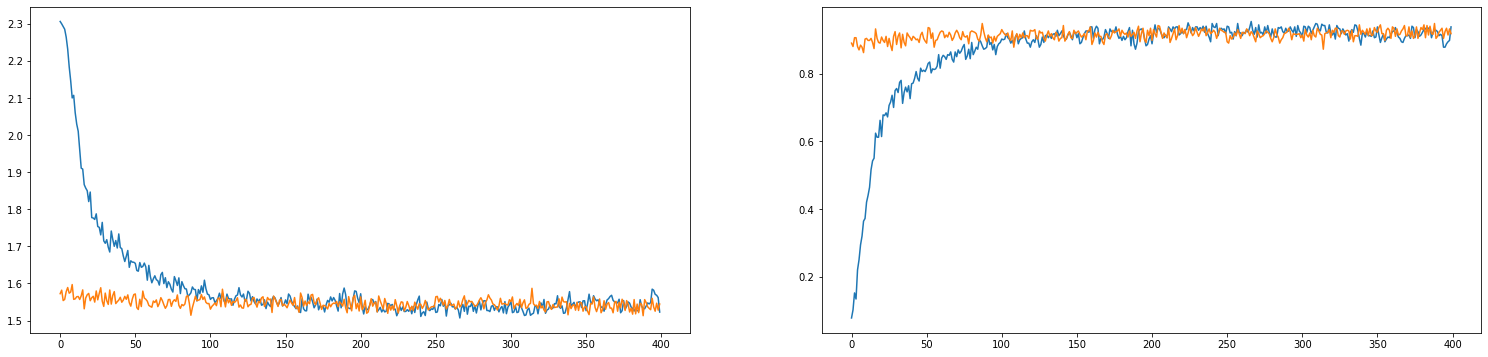

In [235]:
plt.figure(figsize=(26, 6))
plt.subplot(1,2,1)
plt.plot(tloss)
plt.plot(tloss1)
plt.subplot(1,2,2)
plt.plot(taccu)
plt.plot(taccu1)


In [236]:
vloss, vaccu = test(cnn_model, valid_ds)
print('valid loss is %f'%vloss)
print('valid accu is %f'%vaccu)

Instructions for updating:
Please use `model.predict()` instead.
valid loss is 1.507066
valid accu is 0.954100


In [240]:
cnn_model.predict(x_test)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.2172349e-34, 1.0000000e+00, 9.5933787e-17, ..., 8.8423853e-25,
        1.4212025e-19, 2.4580341e-28],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.2521491e-30,
        1.1912651e-20, 1.1569419e-12],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        4.1161860e-18, 2.4169061e-38],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)